# Demand Forecasting

## Outline

- 1.0 Data Preprocessing
- 1.1. Load and Prepare Sales Data
- 1.1.1. Filter for Relevant Sub-Categories
- 1.1.2. Aggregate Sales Data to Weekly Totals per Sub-Category
- 1.2. Visualize the Time Series
- 2.0. Model Development
- 2.1. Define a Function to Split Data
- 2.1.1. ARIMA/SARIMA Models
- 2.2. Exponential Smoothing Methods
- 2.2.1. Apply Exponential Smoothing to Each Sub-Category
- 2.3. Machine Learning Models
- 2.3.1. Random Forest Regression
- 2.3.2. Gradient Boosting Machines
- 3.0. Model Evaluation
- 3.1. Evaluate Models Using Metrics
- 4.0. Forecast Visualization
- 4.1. Residual Analysis

## 1. Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Time series models
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Machine Learning Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit


In [4]:
sales_orders_path = path +'/sales_orders.csv'

order_line_items_path = path +'/order_line_items.csv' 

products_path = path +'/products.csv'

backorders_path = path +'/backorders.csv'

sales_orders = pd.read_csv(sales_orders_path)

order_line_items = pd.read_csv(order_line_items_path)

products = pd.read_csv(products_path)

backorders = pd.read_csv(backorders_path)



### 1.1. Load and Prepare Sales Data

In [5]:
# Ensure date columns are in datetime format
backorders['order_date'] = pd.to_datetime(backorders['order_date'])
backorders['expected_delivery_date'] = pd.to_datetime(backorders['expected_delivery_date'])

# Merge sales orders with order line items
sales_data = pd.merge(sales_orders, order_line_items, on='order_id')

# Merge with products to get sub-category
sales_data = pd.merge(sales_data, products[['product_id', 'sub_category']], on='product_id')

# Merge sales data with backorders data on relevant columns
sales_data = pd.merge(
    sales_data,
    backorders[['order_id', 'product_id', 'backorder_quantity']],
    on=['order_id', 'product_id'],
    how='left'
)

# Fill NaN in backorder_quantity with 0, as not all orders have backorders
sales_data['backorder_quantity'] = sales_data['backorder_quantity'].fillna(0)

# Add backordered quantities to quantity_ordered
sales_data['quantity_ordered'] = sales_data['quantity_ordered'] + sales_data['backorder_quantity']

#### 1.1.1. Filter for Relevant Sub-Categories

In [6]:
sub_categories_apparel = ['Jackets', 'Pants', 'Shirts']
sub_categories_equipment = ['Backpacks', 'Tents', 'Sleeping Bags']

# Combine all sub-categories
sub_categories = sub_categories_apparel + sub_categories_equipment

# Filter sales data for these sub-categories
sales_data = sales_data[sales_data['sub_category'].isin(sub_categories)]


#### 1.1.2. Aggregate Sales Data to Weekly Totals per Sub-Category

In [7]:
# Ensure 'order_date' is a datetime object
sales_data['order_date'] = pd.to_datetime(sales_data['order_date'])

# Set 'order_date' as index
sales_data.set_index('order_date', inplace=True)

# Resample data to weekly frequency and aggregate sales
weekly_sales = sales_data.groupby('sub_category').resample('W')['quantity_ordered'].sum().reset_index()

# Pivot data to have sub-categories as columns
weekly_sales_pivot = weekly_sales.pivot(index='order_date', columns='sub_category', values='quantity_ordered').fillna(0)


### 1.2. Visualize the Time Series

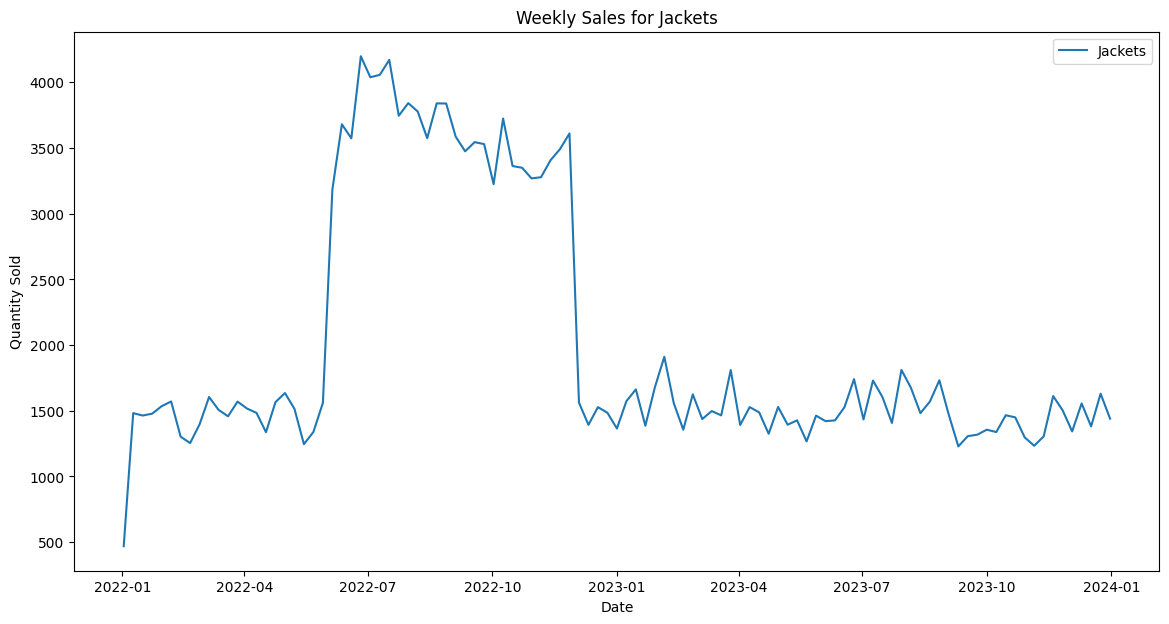

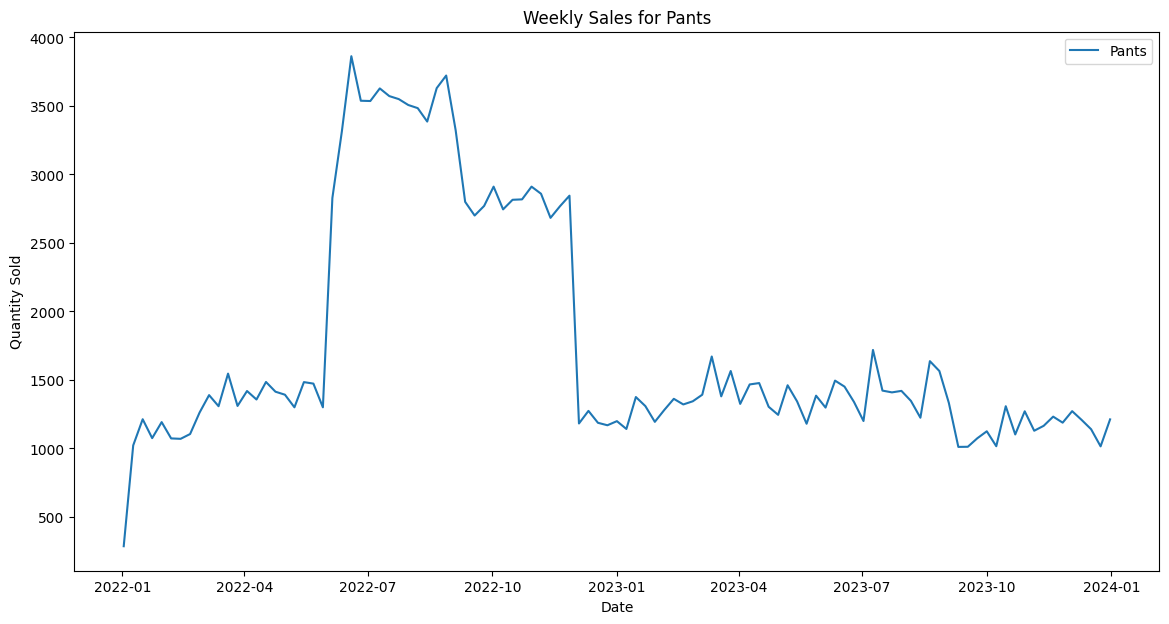

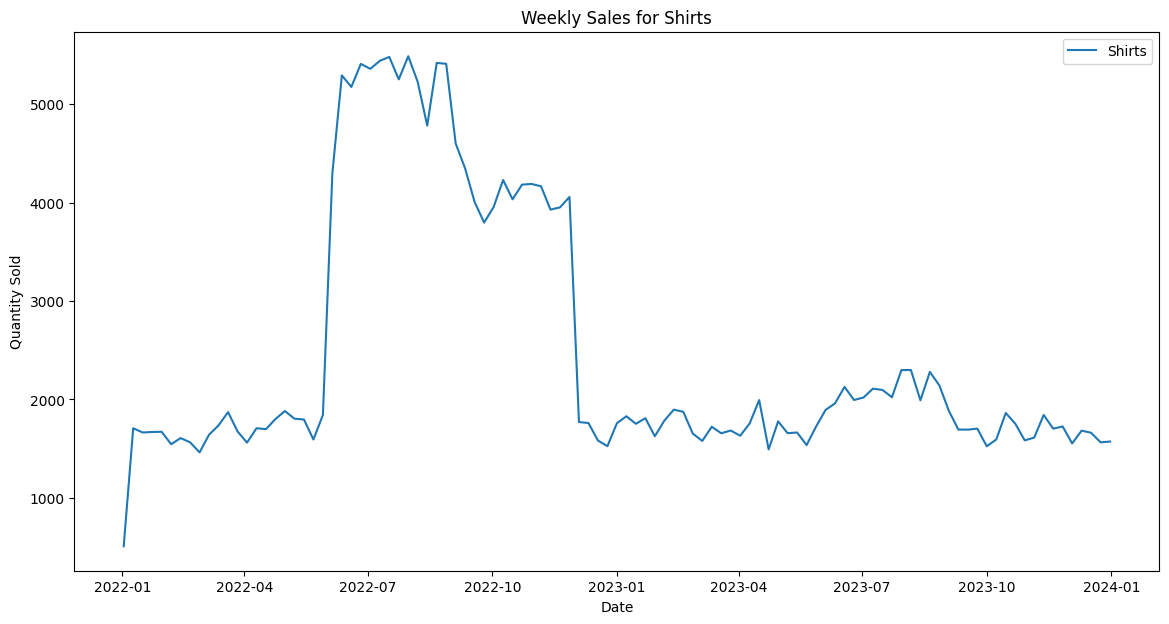

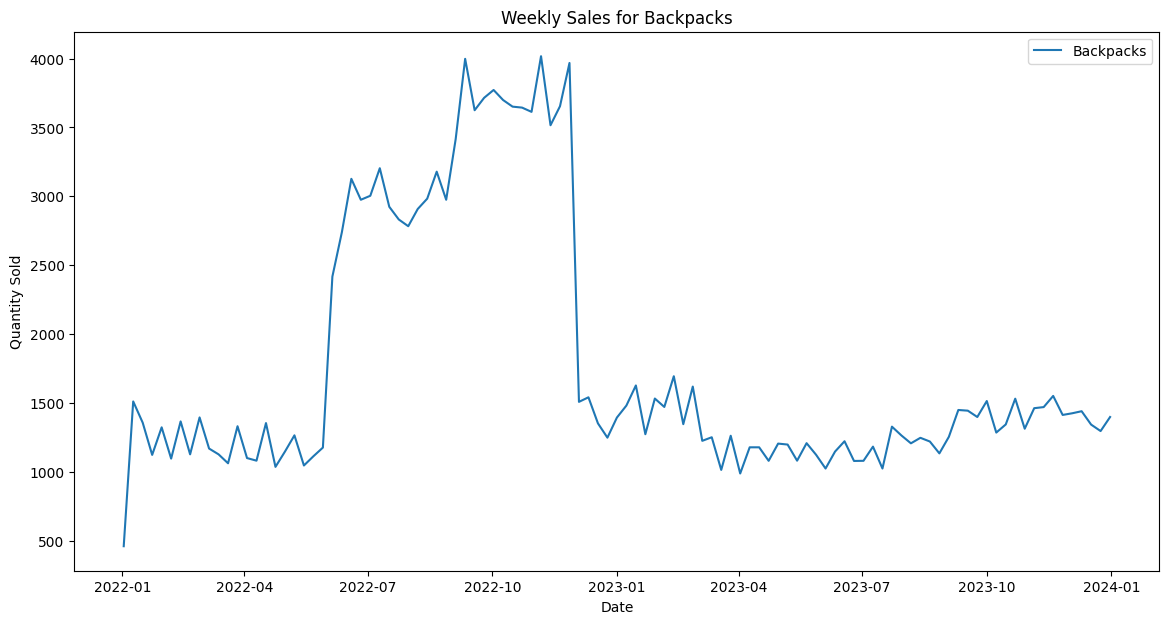

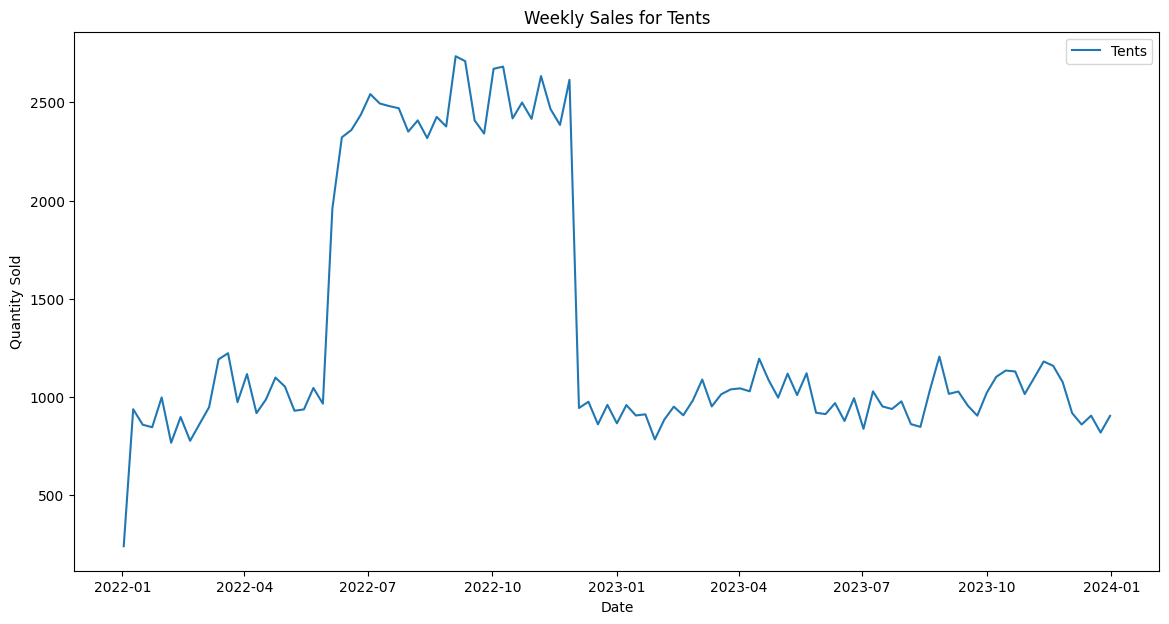

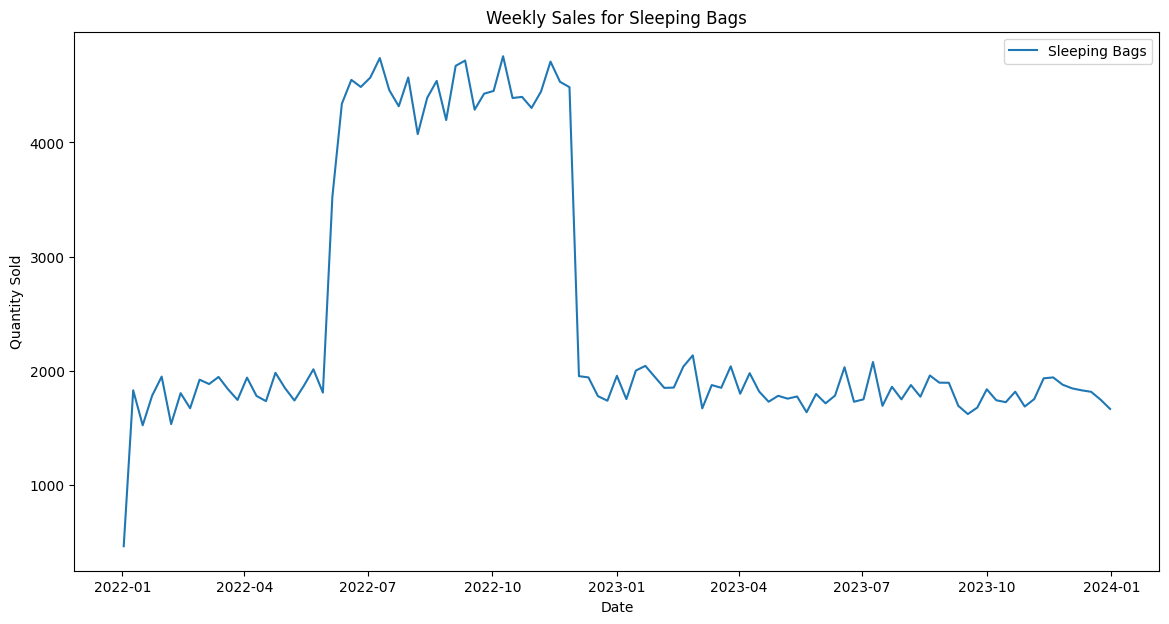

In [8]:
for sub_category in sub_categories:
    plt.figure(figsize=(14, 7))
    plt.plot(weekly_sales_pivot.index, weekly_sales_pivot[sub_category], label=sub_category)
    plt.title(f'Weekly Sales for {sub_category}')
    plt.xlabel('Date')
    plt.ylabel('Quantity Sold')
    plt.legend()
    plt.show()

## 2. Model Development

### 2.1 Define a Function to Split Data

In [9]:
def train_test_split_time_series(data, test_size=12):
    train = data[:-test_size]
    test = data[-test_size:]
    return train, test


#### 2.1.1. ARIMA/SARIMA Models

In [10]:
def sarima_forecast(train, test, order, seasonal_order):
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    forecast = model_fit.predict(start=test.index[0], end=test.index[-1], dynamic=False)
    return forecast, model_fit

In [11]:
from statsmodels.tsa.stattools import adfuller

def find_best_sarima_params(train):
    # For simplicity, we'll try a few combinations
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 52) for x in pdq]  # 52 weeks in a year

    best_aic = np.inf
    best_order = None
    best_seasonal_order = None

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(train, order=param, seasonal_order=param_seasonal,
                                enforce_stationarity=False, enforce_invertibility=False)
                results = model.fit(disp=False)
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = param
                    best_seasonal_order = param_seasonal
            except:
                continue
    return best_order, best_seasonal_order


In [12]:
forecast_results = {}

for sub_category in sub_categories:
    data = weekly_sales_pivot[sub_category]
    train, test = train_test_split_time_series(data)

    # Find best SARIMA parameters
    order, seasonal_order = find_best_sarima_params(train)

    # Generate forecast
    forecast, model_fit = sarima_forecast(train, test, order, seasonal_order)

    # Store results
    forecast_results[sub_category] = {
        'train': train,
        'test': test,
        'forecast': forecast,
        'model_fit': model_fit
    }

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(test, forecast))
    print(f'SARIMA Model for {sub_category} - RMSE: {rmse:.2f}')

SARIMA Model for Jackets - RMSE: 1521.91
SARIMA Model for Pants - RMSE: 1236.46
SARIMA Model for Shirts - RMSE: 1798.56
SARIMA Model for Backpacks - RMSE: 1750.27
SARIMA Model for Tents - RMSE: 1057.59
SARIMA Model for Sleeping Bags - RMSE: 2023.23


### 2.2. Exponential Smoothing Methods

In [13]:
def exponential_smoothing_forecast(train, test, seasonal_periods):
    model = ExponentialSmoothing(train, seasonal='add', trend='add', seasonal_periods=seasonal_periods)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    return forecast, model_fit


#### 2.2.1. Apply Exponential Smoothing to Each Sub-Category

In [14]:
for sub_category in sub_categories:
    data = weekly_sales_pivot[sub_category]
    train, test = train_test_split_time_series(data)

    # Generate forecast
    forecast, model_fit = exponential_smoothing_forecast(train, test, seasonal_periods=12)

    # Store results
    forecast_results[sub_category]['exp_smoothing'] = {
        'forecast': forecast,
        'model_fit': model_fit
    }

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(test, forecast))
    print(f'Exponential Smoothing for {sub_category} - RMSE: {rmse:.2f}')


Exponential Smoothing for Jackets - RMSE: 235.96
Exponential Smoothing for Pants - RMSE: 313.33
Exponential Smoothing for Shirts - RMSE: 226.76
Exponential Smoothing for Backpacks - RMSE: 142.13
Exponential Smoothing for Tents - RMSE: 172.52
Exponential Smoothing for Sleeping Bags - RMSE: 191.21


### 2.3 Machine Learning Models

In [15]:
def create_features(df, label=None):
    df = df.copy()
    df['date'] = df.index
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df['dayofweek'] = df['date'].dt.dayofweek
    X = df[['weekofyear', 'month', 'quarter', 'year', 'dayofweek']]
    if label:
        y = df[label]
        return X, y
    return X


#### 2.3.1 Random Forest Regression

In [16]:
from sklearn.model_selection import train_test_split

for sub_category in sub_categories:
    data = weekly_sales_pivot[sub_category]
    df = pd.DataFrame({'sales': data})
    X, y = create_features(df, label='sales')

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=12, shuffle=False)

    # Model
    model = RandomForestRegressor(n_estimators=100)
    model.fit(X_train, y_train)

    # Forecast
    forecast = model.predict(X_test)

    # Store results
    forecast_results[sub_category]['random_forest'] = {
        'forecast': pd.Series(forecast, index=y_test.index),
        'model': model
    }

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, forecast))
    print(f'Random Forest for {sub_category} - RMSE: {rmse:.2f}')


Random Forest for Jackets - RMSE: 152.91
Random Forest for Pants - RMSE: 162.80
Random Forest for Shirts - RMSE: 126.99
Random Forest for Backpacks - RMSE: 80.19
Random Forest for Tents - RMSE: 128.71
Random Forest for Sleeping Bags - RMSE: 89.10


#### 2.3.2. Gradient Boosting Machines

In [17]:
for sub_category in sub_categories:
    data = weekly_sales_pivot[sub_category]
    df = pd.DataFrame({'sales': data})
    X, y = create_features(df, label='sales')

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=12, shuffle=False)

    # Model
    model = GradientBoostingRegressor(n_estimators=100)
    model.fit(X_train, y_train)

    # Forecast
    forecast = model.predict(X_test)

    # Store results
    forecast_results[sub_category]['gradient_boosting'] = {
        'forecast': pd.Series(forecast, index=y_test.index),
        'model': model
    }

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, forecast))
    print(f'Gradient Boosting for {sub_category} - RMSE: {rmse:.2f}')


Gradient Boosting for Jackets - RMSE: 161.84
Gradient Boosting for Pants - RMSE: 174.58
Gradient Boosting for Shirts - RMSE: 192.54
Gradient Boosting for Backpacks - RMSE: 131.40
Gradient Boosting for Tents - RMSE: 167.29
Gradient Boosting for Sleeping Bags - RMSE: 64.12


## 3. Model Evaluation

### 3.1. Evaluate Models Using Metrics

In [18]:
for sub_category in sub_categories:
    print(f'\nModel Evaluation for {sub_category}:')
    test = forecast_results[sub_category]['test']

    # SARIMA
    sarima_forecast = forecast_results[sub_category]['forecast']
    sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))
    sarima_mae = mean_absolute_error(test, sarima_forecast)

    # Exponential Smoothing
    exp_forecast = forecast_results[sub_category]['exp_smoothing']['forecast']
    exp_rmse = np.sqrt(mean_squared_error(test, exp_forecast))
    exp_mae = mean_absolute_error(test, exp_forecast)

    # Random Forest
    rf_forecast = forecast_results[sub_category]['random_forest']['forecast']
    rf_rmse = np.sqrt(mean_squared_error(test, rf_forecast))
    rf_mae = mean_absolute_error(test, rf_forecast)

    # Gradient Boosting
    gb_forecast = forecast_results[sub_category]['gradient_boosting']['forecast']
    gb_rmse = np.sqrt(mean_squared_error(test, gb_forecast))
    gb_mae = mean_absolute_error(test, gb_forecast)

    # Print Metrics
    print(f'SARIMA - RMSE: {sarima_rmse:.2f}, MAE: {sarima_mae:.2f}')
    print(f'Exponential Smoothing - RMSE: {exp_rmse:.2f}, MAE: {exp_mae:.2f}')
    print(f'Random Forest - RMSE: {rf_rmse:.2f}, MAE: {rf_mae:.2f}')
    print(f'Gradient Boosting - RMSE: {gb_rmse:.2f}, MAE: {gb_mae:.2f}')



Model Evaluation for Jackets:
SARIMA - RMSE: 1521.91, MAE: 1221.00
Exponential Smoothing - RMSE: 235.96, MAE: 200.60
Random Forest - RMSE: 152.91, MAE: 124.26
Gradient Boosting - RMSE: 161.84, MAE: 123.01

Model Evaluation for Pants:
SARIMA - RMSE: 1236.46, MAE: 972.83
Exponential Smoothing - RMSE: 313.33, MAE: 288.90
Random Forest - RMSE: 162.80, MAE: 147.66
Gradient Boosting - RMSE: 174.58, MAE: 151.91

Model Evaluation for Shirts:
SARIMA - RMSE: 1798.56, MAE: 1417.83
Exponential Smoothing - RMSE: 226.76, MAE: 154.69
Random Forest - RMSE: 126.99, MAE: 97.44
Gradient Boosting - RMSE: 192.54, MAE: 173.17

Model Evaluation for Backpacks:
SARIMA - RMSE: 1750.27, MAE: 1352.00
Exponential Smoothing - RMSE: 142.13, MAE: 114.38
Random Forest - RMSE: 80.19, MAE: 68.01
Gradient Boosting - RMSE: 131.40, MAE: 99.22

Model Evaluation for Tents:
SARIMA - RMSE: 1057.59, MAE: 834.25
Exponential Smoothing - RMSE: 172.52, MAE: 147.35
Random Forest - RMSE: 128.71, MAE: 112.38
Gradient Boosting - RMSE:

## 4.  Forecast Visulaization

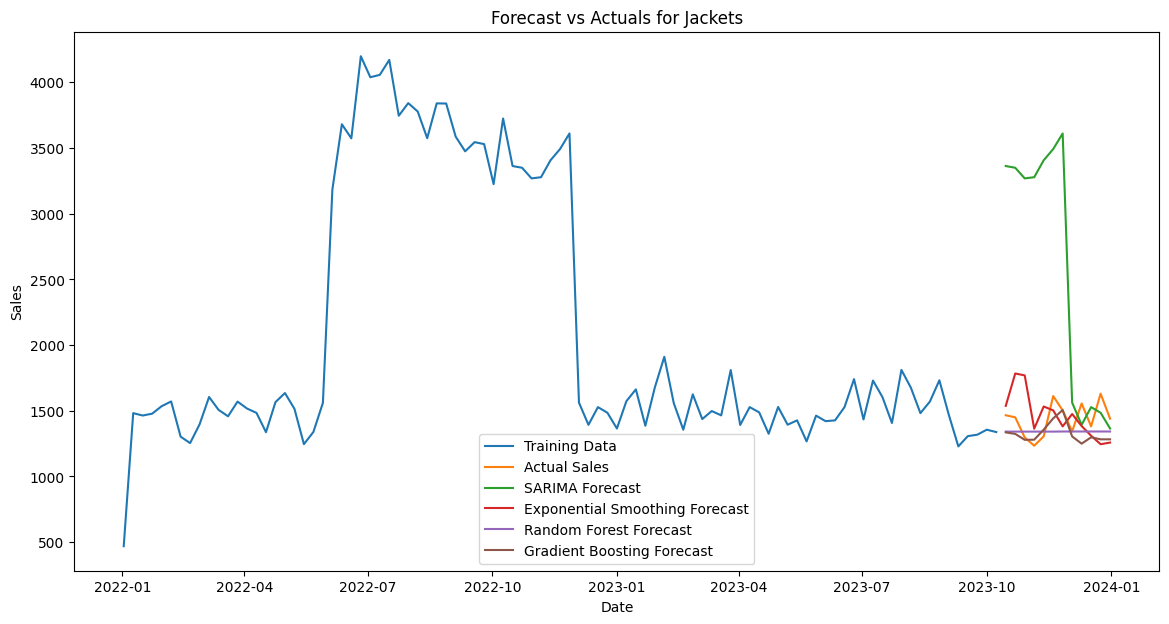

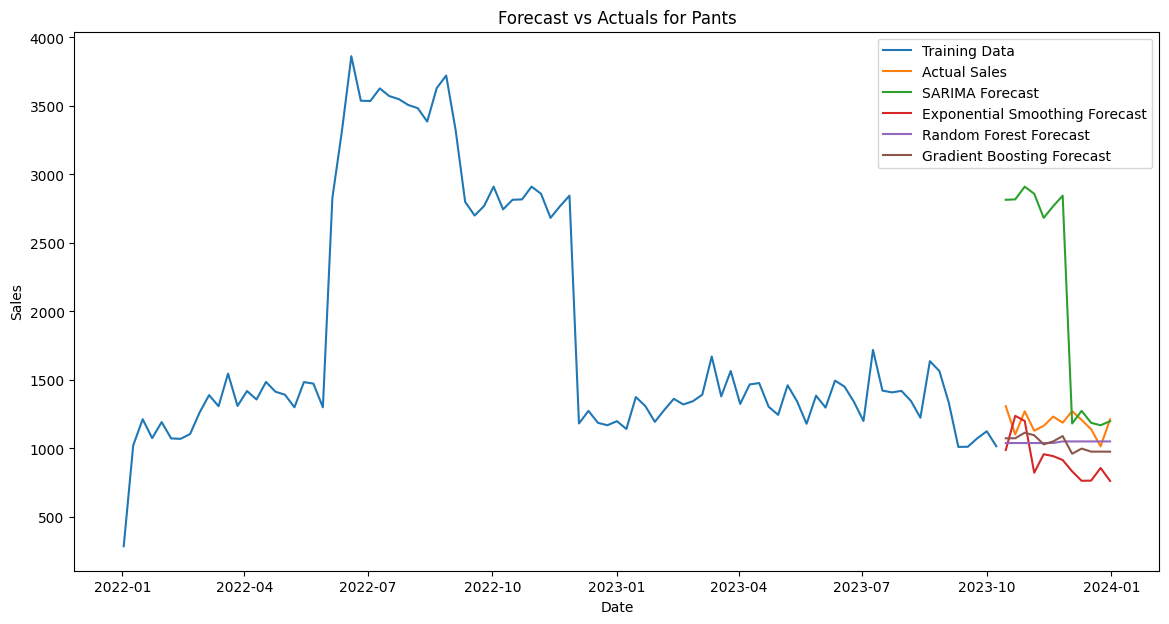

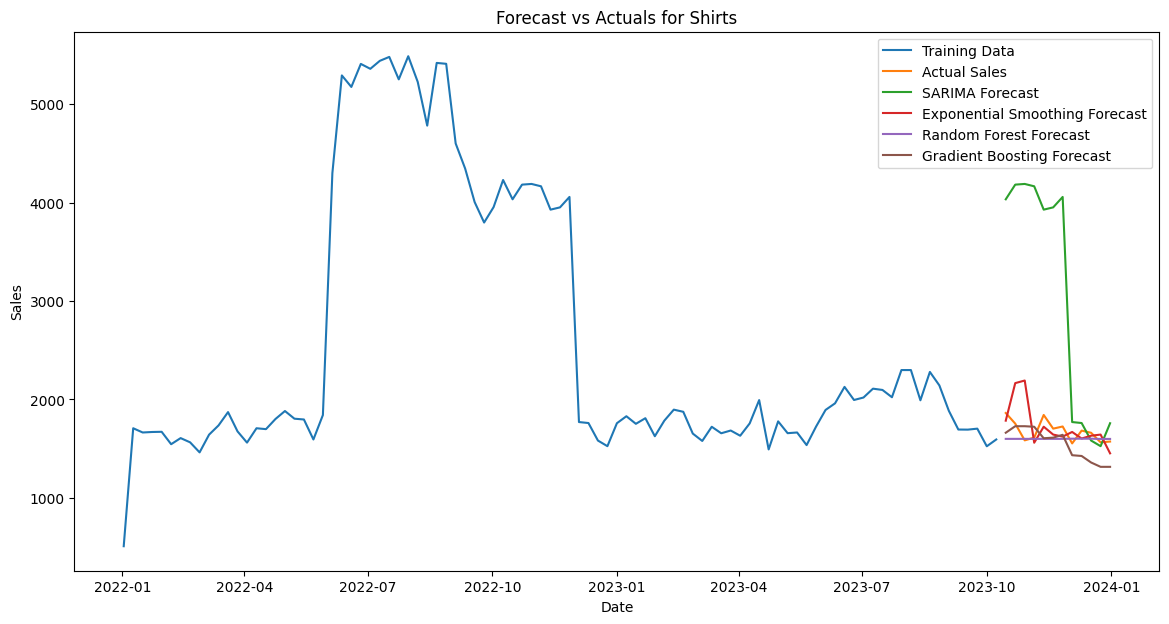

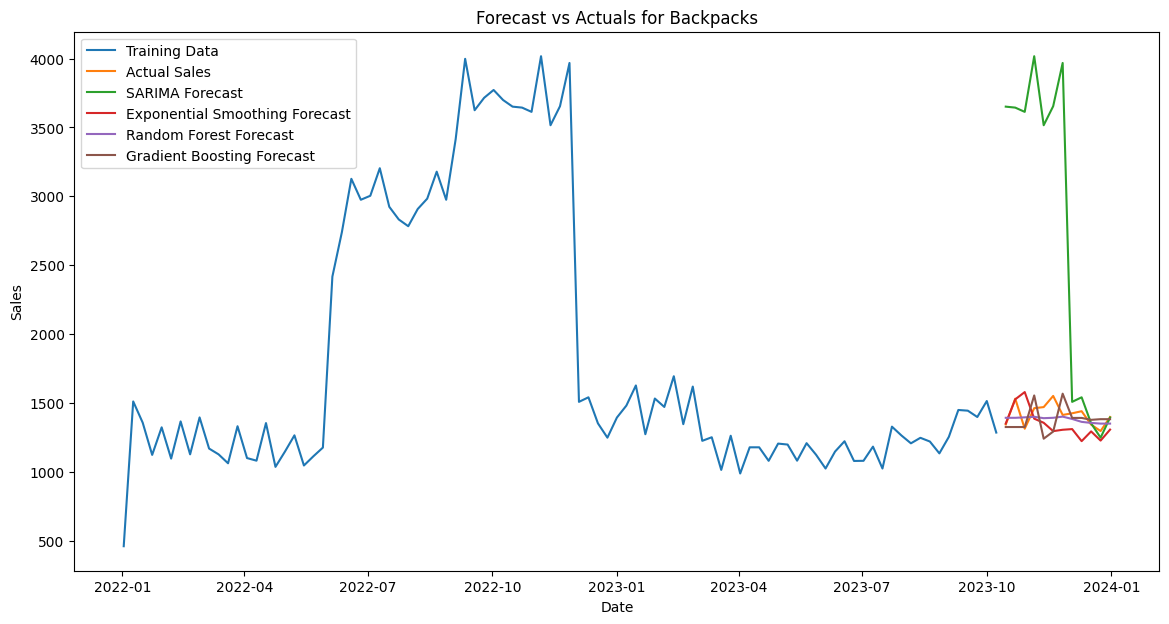

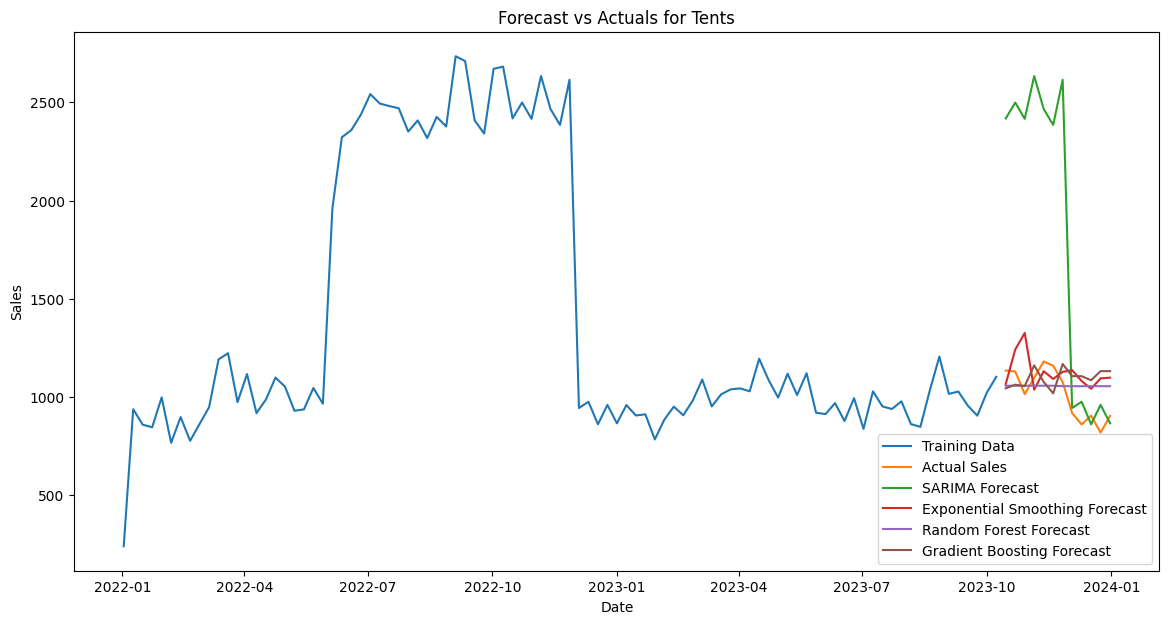

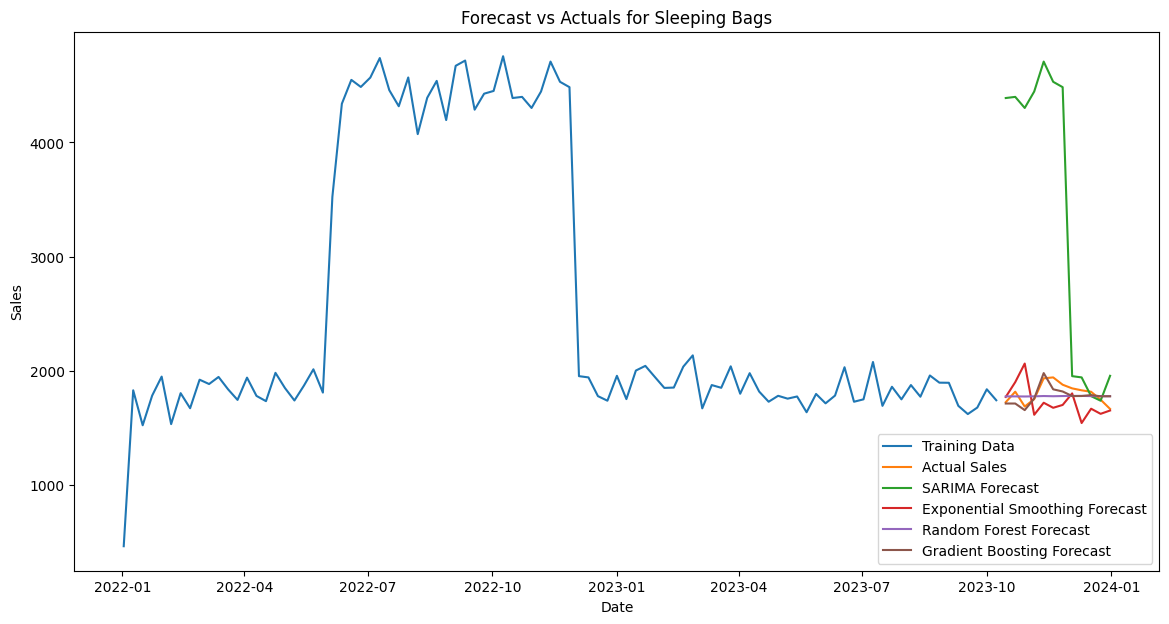

In [19]:
for sub_category in sub_categories:
    train = forecast_results[sub_category]['train']
    test = forecast_results[sub_category]['test']
    sarima_forecast = forecast_results[sub_category]['forecast']
    exp_forecast = forecast_results[sub_category]['exp_smoothing']['forecast']
    rf_forecast = forecast_results[sub_category]['random_forest']['forecast']
    gb_forecast = forecast_results[sub_category]['gradient_boosting']['forecast']

    plt.figure(figsize=(14, 7))
    plt.plot(train.index, train, label='Training Data')
    plt.plot(test.index, test, label='Actual Sales')
    plt.plot(sarima_forecast.index, sarima_forecast, label='SARIMA Forecast')
    plt.plot(exp_forecast.index, exp_forecast, label='Exponential Smoothing Forecast')
    plt.plot(rf_forecast.index, rf_forecast, label='Random Forest Forecast')
    plt.plot(gb_forecast.index, gb_forecast, label='Gradient Boosting Forecast')
    plt.title(f'Forecast vs Actuals for {sub_category}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()


### 4.1 Residual Analysis

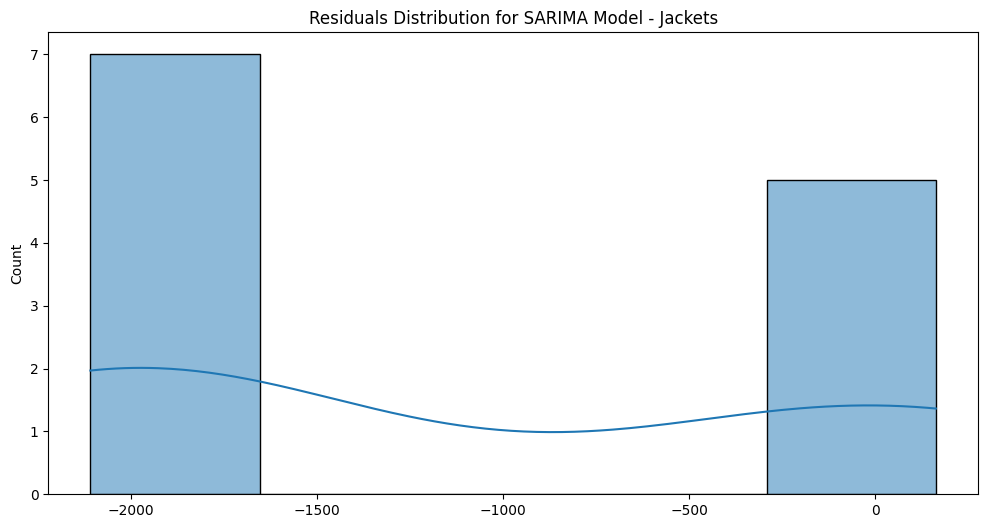

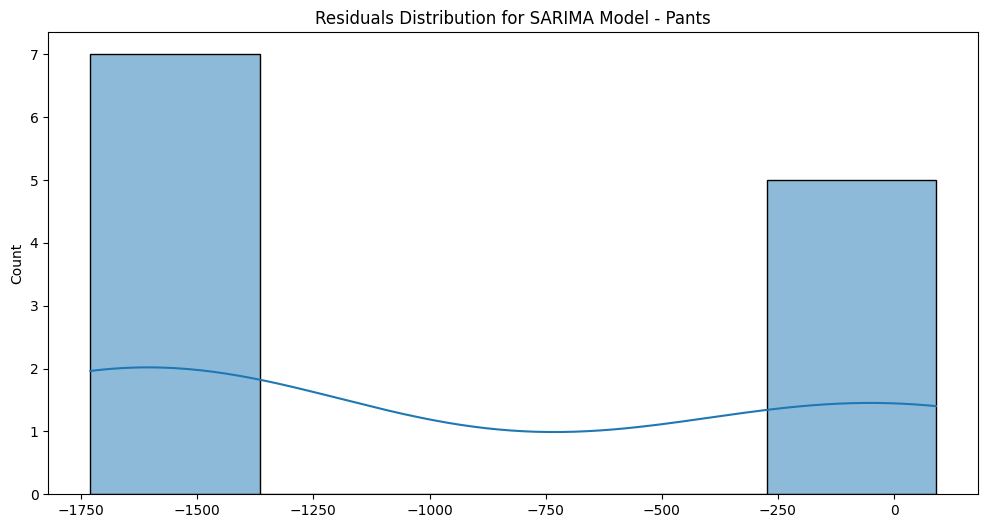

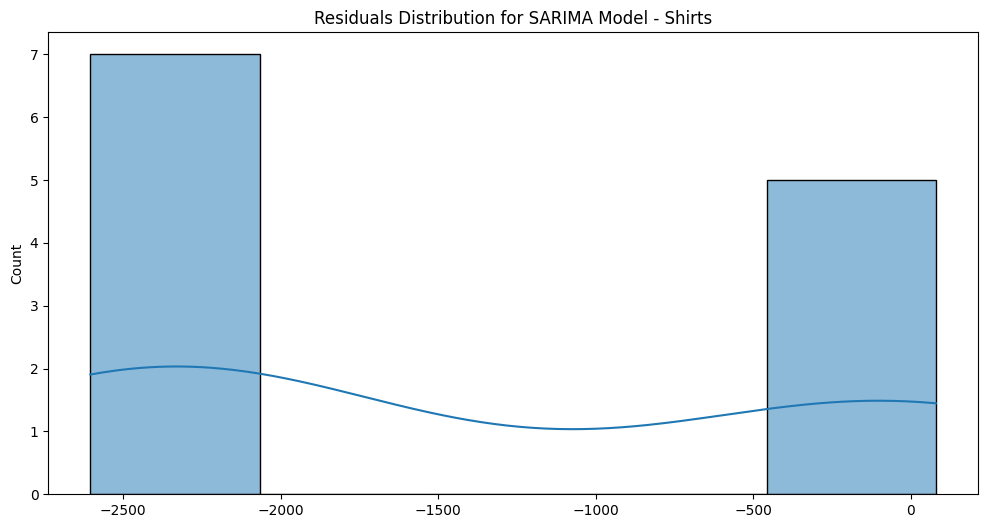

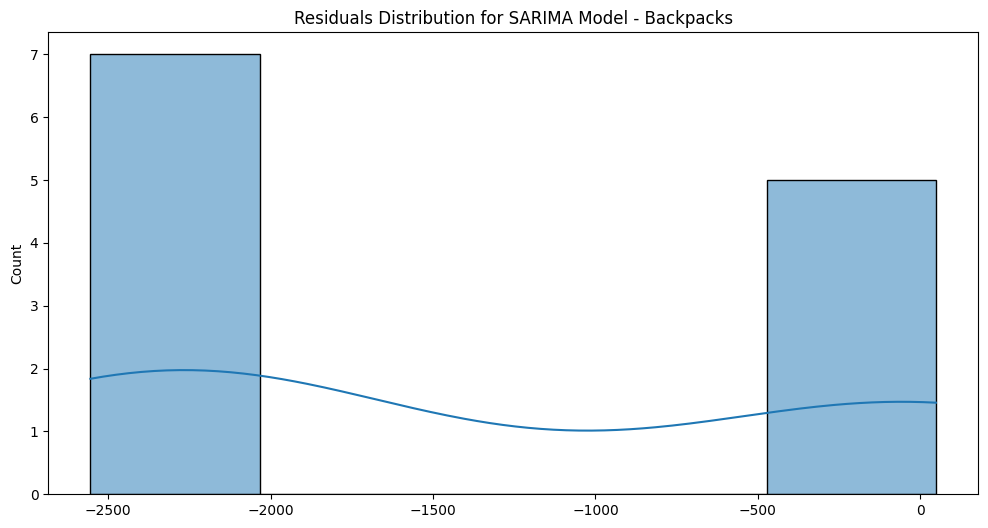

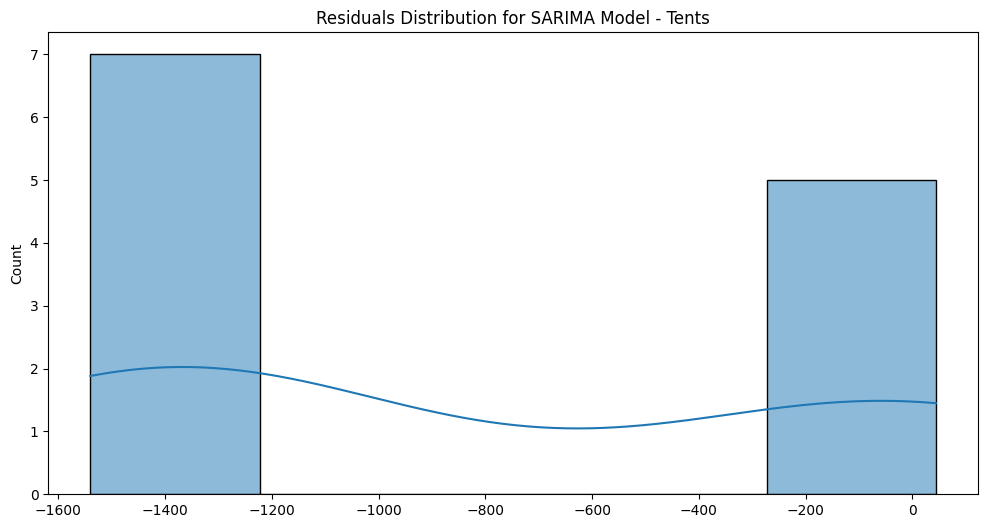

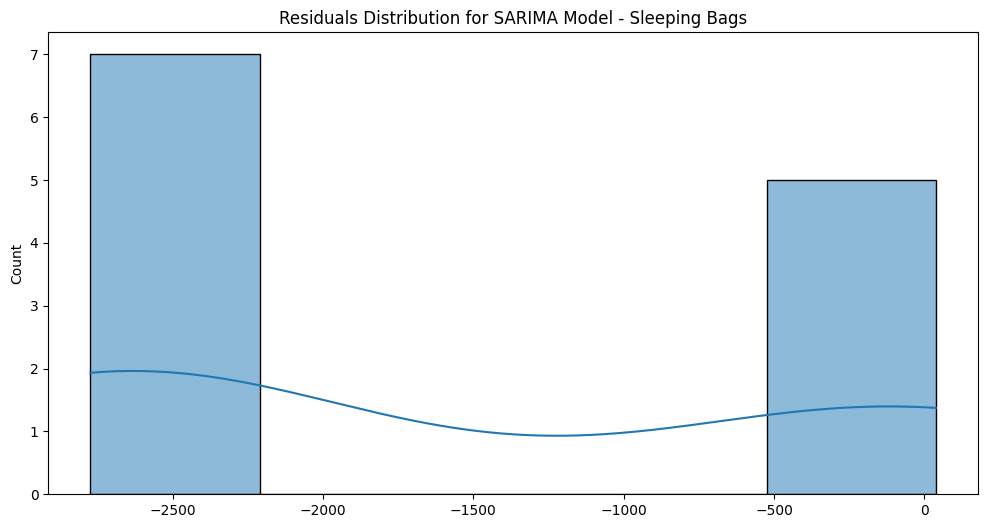

In [20]:
for sub_category in sub_categories:
    residuals = forecast_results[sub_category]['test'] - forecast_results[sub_category]['forecast']
    plt.figure(figsize=(12, 6))
    sns.histplot(residuals, kde=True)
    plt.title(f'Residuals Distribution for SARIMA Model - {sub_category}')
    plt.show()
